In [27]:
import numpy
import torch
from torchvision import datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import random_split, DataLoader

Load CIFAR-10 dataset and split

In [28]:
transform = v2.Compose([
    v2.ToTensor()
])

# TODO: Move data prep to its own python script

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# This custom split is from the official training data and does not use the official testing data
generator = torch.Generator().manual_seed(7)
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Min-Max Scaling to [-1,1]

In [4]:
def compute_min_max(dataset):
    min_unscaled = float("inf")
    max_unscaled = float("-inf")
    for i in range(len(dataset)):
        x, _ = dataset[i]
        min_unscaled = min(min_unscaled, x.min().item())
        max_unscaled = max(max_unscaled, x.max().item())
    return min_unscaled, max_unscaled

class MinMaxScaling:
    def __init__(self, min_unscaled, max_unscaled, min_scaled, max_scaled):
        self.min_unscaled = min_unscaled
        self.max_unscaled = max_unscaled
        self.min_scaled = min_scaled
        self.max_scaled = max_scaled
    
    def __call__(self, x):
        return ((x-self.min_unscaled)/(self.max_unscaled-self.min_unscaled))*(self.max_scaled-self.min_scaled)+self.min_scaled

Z-score Normalization

In [5]:
def compute_mean_std(dataset):
    x0, _ = dataset[0] # get first image from dataset to extract dimensions
    c = x0.shape[0]

    sum_n = torch.zeros(c)
    sum_sq = torch.zeros(c)
    num_pixels = 0

    for i in range(len(dataset)):
        x, _ = dataset[i]
        sum_n += x.sum(dim=(1,2))
        sum_sq += (x ** 2).sum(dim=(1,2))
        num_pixels += x.shape[1] * x.shape[2]
    
    mean = sum_n / num_pixels
    std = torch.sqrt(sum_sq / num_pixels - mean ** 2)

    return mean, std

Apply the data transformations

In [6]:
data_mean, data_std = compute_mean_std(train_set)
data_min, data_max = compute_min_max(train_set)

train_set.transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=data_mean, std=data_std),
    MinMaxScaling(data_min, data_max, 0, 1),

    v2.RandomHorizontalFlip(p=0.5), # add ability to control these parameters later
    v2.RandomCrop((16,16)),
    v2.GaussianNoise(mean=0, sigma=0.1),
    v2.ColorJitter()
])

Preview the data

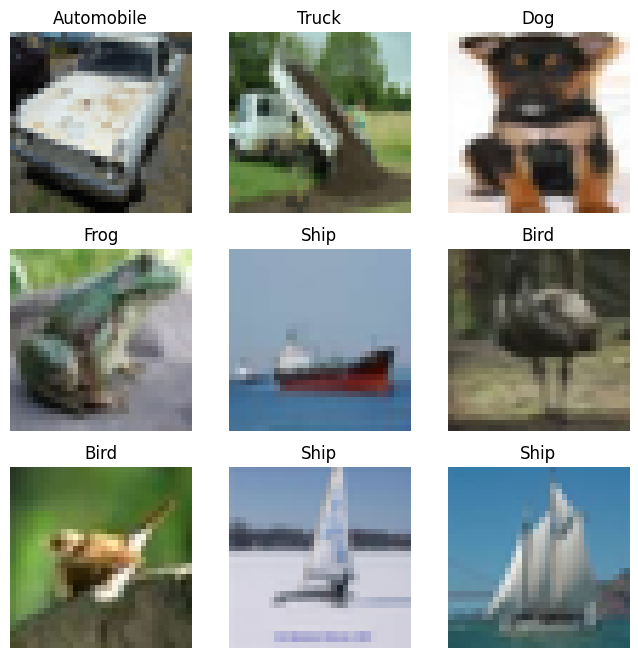

In [7]:
import matplotlib.pyplot as plt

labels = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

Create data loaders

In [29]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

images, _ = next(iter(train_loader))
print(images.min().item(), images.max().item())
print(images.mean().item(), images.std().item())

0.0 1.0
0.4661920368671417 0.2475212812423706


Configure supervised neural network, optimizer and loss function

In [34]:
from model_supervised import SupervisedNetwork
import torch.nn as nn
import torch.optim as optim

# TODO: add more parameter options
lr = 0.01
momentum = 0.9

model = SupervisedNetwork()

criterion = nn.CrossEntropyLoss() # softmax is applied internally
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Train supervised neural network

In [35]:
epochs = 10

for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:

        optimizer.zero_grad() # zero gradients

        outputs = model(images)  # forward pass
        loss = criterion(outputs, labels)

        loss.backward() # backpropigate error
        optimizer.step() # update parameters

        training_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    training_loss /= total
    train_acc = correct / total

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {training_loss:.4f}, Train Accuracy: {train_acc:.4f}"
    )

Epoch [1/10] | Train Loss: 2.3025, Train Accuracy: 0.0994
Epoch [2/10] | Train Loss: 2.3019, Train Accuracy: 0.1254
Epoch [3/10] | Train Loss: 2.2805, Train Accuracy: 0.1402
Epoch [4/10] | Train Loss: 2.2375, Train Accuracy: 0.1969
Epoch [5/10] | Train Loss: 2.1698, Train Accuracy: 0.2847
Epoch [6/10] | Train Loss: 2.1272, Train Accuracy: 0.3283
Epoch [7/10] | Train Loss: 2.0921, Train Accuracy: 0.3630
Epoch [8/10] | Train Loss: 2.0642, Train Accuracy: 0.3895
Epoch [9/10] | Train Loss: 2.0446, Train Accuracy: 0.4114
Epoch [10/10] | Train Loss: 2.0279, Train Accuracy: 0.4282
